### Clusteringul filmelor dupa caracteristici financiare si de popularitate

In aceasta etapa am aplicat o metoda de clustering ne-supervizata (KMeans) pentru a grupa filmele in functie de asemanarile dintre ele.
Scopul analizei a fost sa identificam tipare naturale in performanta financiara a filmelor si sa determinam daca acestea se pot separa in trei categorii distincte pe baza succesului lor.

Cum am procedat:
1. Selectia variabilelor relevante

Pentru clustering am folosit doar variabile numerice care reflecta succesul real al filmelor:

- budget_log – bugetul filmului 

- revenue_log – veniturile filmului 

- vote_count – numarul total de voturi primite

- vote_average – ratingul mediu

- popularity – scorul de popularitate

- runtime_log – durata filmului



2. Scalarea datelor

Variabilele au scari diferite, de aceea am folosit StandardScaler.
KMeans este sensibil la scara datelor, deci standardizarea este necesara pentru a trata fiecare variabila cu importanta egala.

3. Determinarea numarului optim de clustere

Nu am ales numarul de clustere manual.
Am testat valori k de la 2 la 9 si am calculat Silhouette Score pentru fiecare.
Valoarea maxima a fost obtinuta pentru k = 3, ceea ce indica faptul ca datele se separa cel mai bine in trei grupuri.

4. Aplicarea KMeans cu k = 3

Am antrenat modelul KMeans cu parametrii:

n_clusters = 3

random_state = 42 pentru reproducibilitate

Fiecarui film i s-a atribuit un cluster (0, 1 sau 2), salvat in coloana cluster.

5. Analiza centroizilor

Am calculat diferentele dintre centroizii celor trei clustere pentru a identifica ce variabile contribuie cel mai mult la separarea filmelor.
Variabilele cu diferente mai mari sunt cele mai importante in formarea clusterelor.

**De ce am facut acest clustering:**

Pentru a identifica automat trei tipuri principale de filme pe baza succesului lor financiar si a popularitatii.

Pentru a obtine o eticheta (movie_class) utila in taskul urmator de clasificare supravegheata.

Pentru a observa daca filmele se impart natural in:

filme modeste (cluster 0)

filme medii (cluster 1)

blockbustere (cluster 2)

In [45]:
import pandas as pd
df_clean = pd.read_excel("cleaned_movies_metadata.xlsx")

df_financial shape: (5381, 44)
k = 2, Silhouette = 0.2432
k = 3, Silhouette = 0.2752
k = 4, Silhouette = 0.2218
k = 5, Silhouette = 0.1903
k = 6, Silhouette = 0.2083
k = 7, Silhouette = 0.2231
k = 8, Silhouette = 0.2131
k = 9, Silhouette = 0.1940


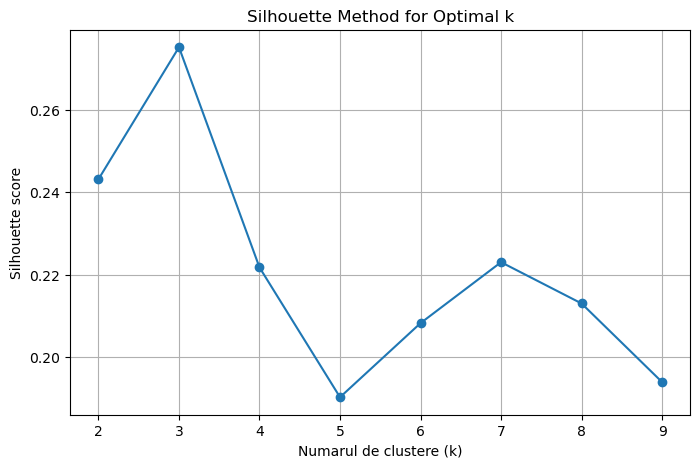

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Selectam doar filmele cu buget si incasari (has_budget = 1, has_revenue = 1)
df_financial = df_clean[(df_clean["has_budget"] == 1) & (df_clean["has_revenue"] == 1)].copy()
print("df_financial shape:", df_financial.shape)

# 2. Definimfeature-urile folosite la clustering
features = [
    "budget_log",
    "revenue_log",
    "vote_average",
    "vote_count",
    "popularity",
    "runtime",      
]

# 3. Construim X 
X = df_financial[features]

# 4. Scalarea datelor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Calculam Silhouette pentru k = 2..9
sil_scores = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)            # antrnaem KMeans pe datele scalate
    sil = silhouette_score(X_scaled, labels)        # calculam Silhouette pe aceleasi date curate
    sil_scores.append(sil)
    print(f"k = {k}, Silhouette = {sil:.4f}")

# 6. Plotul metodei Silhouette
plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Numarul de clustere (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True)
plt.show()


In [47]:

# 1. Antrenam KMeans cu k = 3 
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)   


df_financial["cluster"] = labels

centers = kmeans.cluster_centers_

# 4. Calculam importanta feature-urilor:
#    pentru fiecare feature vedem cat de mult variaza valorile centroizilor
diff = centers.std(axis=0)   # vector cu lungime = len(features)

# 5. Ordonam feature-urile dupa importanta (variatie mai mare = influenta mai mare)
feature_importance = sorted(
    zip(features, diff),
    key=lambda x: x[1],
    reverse=True
)

print("Importanta feature-urilor in separarea clusterelor pentru k = 3:\n")
for feat, val in feature_importance:
    print(f"{feat}: {val:.4f}")


Importanta feature-urilor in separarea clusterelor pentru k = 3:

vote_count: 1.5202
revenue_log: 0.9624
popularity: 0.8025
budget_log: 0.7858
vote_average: 0.5525
runtime: 0.5370


In [48]:
# ===============================
# Mapping corect cluster -> clasa
# ===============================

# 1. Calculam media financiara pentru fiecare cluster
cluster_summary = (
    df_financial
    .groupby("cluster")[["revenue_log", "vote_count", "popularity"]]
    .mean()
    .sort_values("revenue_log")   # ordonam de la cel mai slab la cel mai bun
)

print("\nRezumat clustere (ordonate dupa revenue_log):")
print(cluster_summary)

# 2. Ordinea clusterelor dupa succes financiar
order = cluster_summary.index.tolist()   # ex: [0, 2, 1]

# 3. Construim harta corecta
label_map = {
    order[0]: "film_modest",
    order[1]: "film_mediu",
    order[2]: "blockbuster"
}

# 4. Aplicam etichetele
df_financial["movie_class"] = df_financial["cluster"].map(label_map)

# ===============================
# FEATURES PENTRU CLASIFICARE
# ===============================

lang_cols  = [c for c in df_financial.columns if c.startswith("original_language_")]
genre_cols = [c for c in df_financial.columns if c.startswith("main_genre_")]

df_financial["release_year"] = pd.to_datetime(df_financial["release_date"]).dt.year

features_clf = ["release_year"] + lang_cols + genre_cols

X = df_financial[features_clf].copy()
y = df_financial["movie_class"].copy()

print("\nShape X:", X.shape)
print("Clase si frecvente in y:")
print(y.value_counts())




Rezumat clustere (ordonate dupa revenue_log):
         revenue_log   vote_count  popularity
cluster                                      
0          13.547121   118.022411    5.001732
2          17.558485   573.565722    9.321172
1          19.616485  4352.814136   30.335783

Shape X: (5381, 20)
Clase si frecvente in y:
movie_class
film_mediu     3705
film_modest    1294
blockbuster     382
Name: count, dtype: int64


In [49]:
df_financial.to_excel("cleaned_movies_metadata.xlsx", index=False)

### Evaluarea overfitting-ului pentru Decision Tree

Pentru a verifica dacă modelul de tip *Decision Tree* suferă de overfitting, am calculat atât metricile pe **setul de antrenare** (train), cât și pe **setul de test** (test), folosind validare încrucișată stratificată 10-fold.

Pentru cea mai bună configurație (după F1 pe test), valorile medii au fost aproximativ:

- **Accuracy (train)** ≈ 0.71  
- **Accuracy (test)** ≈ 0.69  
- **F1 macro (train)** ≈ 0.41  
- **F1 macro (test)** ≈ 0.37  
- **Cohen’s kappa (train)** ≈ 0.19  
- **Cohen’s kappa (test)** ≈ 0.11  

Diferențele dintre train și test (gap-ul de generalizare) sunt relativ mici:

- **Gap Accuracy** ≈ 0.02–0.03  
- **Gap F1** ≈ 0.04–0.05  

Acest lucru indică faptul că modelul **nu suferă de un overfitting**: performanța pe datele de antrenare este doar puțin mai mare decât pe datele de test, ceea ce este de așteptat într-un scenariu realist.




In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, cohen_kappa_score
import numpy as np
import pandas as pd

# CV stratificat (pastreaza proportiile claselor) + shuffle 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Kappa ca scor custom
kappa_scorer = make_scorer(cohen_kappa_score)

# grila de parametri pentru arbore
param_grid = [
    {"max_depth": 3,   "criterion": "gini",    "min_samples_leaf": 1},
    {"max_depth": 5,   "criterion": "gini",    "min_samples_leaf": 5},
    {"max_depth": 10,  "criterion": "entropy", "min_samples_leaf": 5},
    {"max_depth": None,"criterion": "gini",    "min_samples_leaf": 1},
    {"max_depth": None,"criterion": "entropy", "min_samples_leaf": 10},
]

rows = []
for idx, params in enumerate(param_grid):
    clf = DecisionTreeClassifier(**params, random_state=42)
    
    s = cross_validate(
        clf, X, y, cv=cv,
        scoring={
            "accuracy": "accuracy",
            "precision": "precision_macro",
            "recall": "recall_macro",
            "f1": "f1_macro",
            "kappa": kappa_scorer
        },
        return_train_score=True   # scor pe TRAIN
    )
    
    rows.append({
        "grid_idx": idx,
        "max_depth": params["max_depth"],
        "criterion": params["criterion"],
        "min_samples_leaf": params["min_samples_leaf"],
        
        #scoruri pe TEST
        "test_accuracy":  np.mean(s["test_accuracy"]),
        "test_precision": np.mean(s["test_precision"]),
        "test_recall":    np.mean(s["test_recall"]),
        "test_f1":        np.mean(s["test_f1"]),
        "test_kappa":     np.mean(s["test_kappa"]),
        
        #scoruri pe TRAIN
        "train_accuracy":  np.mean(s["train_accuracy"]),
        "train_precision": np.mean(s["train_precision"]),
        "train_recall":    np.mean(s["train_recall"]),
        "train_f1":        np.mean(s["train_f1"]),
        "train_kappa":     np.mean(s["train_kappa"]),
        
        #gap TRAIN/TEST
        "gap_acc": np.mean(s["train_accuracy"]) - np.mean(s["test_accuracy"]),
        "gap_f1":  np.mean(s["train_f1"])      - np.mean(s["test_f1"]),
    })

results_df = pd.DataFrame(rows).sort_values(by="test_f1", ascending=False)

print("Rezultate (sortate dupa F1 pe TEST desc):")
print(results_df[[
    "grid_idx", "max_depth", "criterion", "min_samples_leaf",
    "train_accuracy", "test_accuracy", "gap_acc",
    "train_f1", "test_f1", "gap_f1",
    "train_kappa", "test_kappa"
]])

# cel mai bun rand dupa F1 de TEST
best_row = results_df.iloc[0]
depth = best_row["max_depth"]
if pd.isna(depth):
    final_depth = None
else:
    final_depth = int(depth)
best_params = {
    "n_estimators": 300,                  # Parametru fix pentru Random Forest
    "random_state": 42,
    "n_jobs": -1,
    "max_depth": final_depth,             
    "criterion": best_row["criterion"],   
    "min_samples_leaf": int(best_row["min_samples_leaf"]) 
}
print("\nCea mai buna configuratie (dupa F1 pe TEST):")
print(best_params)
print(
    f"TrainAcc={best_row['train_accuracy']:.3f} | "
    f"TestAcc={best_row['test_accuracy']:.3f} | "
    f"TrainF1={best_row['train_f1']:.3f} | "
    f"TestF1={best_row['test_f1']:.3f} | "
    f"TrainKappa={best_row['train_kappa']:.3f} | "
    f"TestKappa={best_row['test_kappa']:.3f} | "
    f"GapAcc={best_row['gap_acc']:.3f} | "
    f"GapF1={best_row['gap_f1']:.3f}"
)


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Rezultate (sortate dupa F1 pe TEST desc):
   grid_idx  max_depth criterion  min_samples_leaf  train_accuracy  \
4         4        NaN   entropy                10        0.716885   
3         3        NaN      gini                 1        0.753185   
2         2       10.0   entropy                 5        0.717504   
1         1        5.0      gini                 5        0.707820   
0         0        3.0      gini                 1        0.701893   

   test_accuracy   gap_acc  train_f1   test_f1    gap_f1  train_kappa  \
4       0.686303  0.030582  0.412030  0.368628  0.043402     0.196321   
3       0.668833  0.084352  0.500871  0.363576  0.137295     0.312801   
2       0.689834  0.027670  0.396880  0.349408  0.047472     0.182030   
1       0.696527  0.011292  0.356395  0.341115  0.015280     0.129923   
0       0.698197  0.003696  0.329559  0.324954  0.004605     0.086242   

   test_kappa  
4    0.114085  
3    0.084242  
2    0.100803  
1    0.096682  
0    0.075742  

C

c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Pasul 1 – Analiza clusterelor pentru metoda CIEL

In acest proiect am implementat o versiune partiala a metodei CIEL. Am respectat ideea de baza: datele sunt mai intai grupate in clustere pe baza unor caracteristici financiare, iar pentru fiecare cluster se antreneaza un clasificator local separat, care foloseste atribute non-financiare (gen, limba, anul lansarii). In faza de test, fiecare film este clasificat cu modelul corespunzator clusterului din care face parte.
Nu am implementat insa componenta completa de ensemble din articol (mai multi clasificatori per cluster, medie ponderata a predictiilor, optimizare tip swarm a ponderilor).


Folosim urmatoarele feature-uri financiare:

- vote_count  
- revenue_log  
- popularity  
- budget_log  
- vote_average  
- runtime  

Aceste variabile sunt mai intai standardizate cu StandardScaler, pentru a avea valori comparabile si pentru a evita situatiile in care un feature domina distantele folosite de algoritmii de clustering.

Testam trei algoritmi de clustering, pentru k = 2, 3, 4, 5:

1. **KMeans**  
   Pentru fiecare k calculam:  
   - numarul de elemente in fiecare cluster  
   - scorul silhouette, care masoara cat de bine sunt separate si cat de compacte sunt clusterele  
   Un scor silhouette mai mare indica un clustering mai coerent.

2. **MiniBatchKMeans**  
   Varianta optimizata a KMeans pentru seturi de date mari.  
   Pentru fiecare k afisam:  
   - distributia pe clustere  
   - scorul silhouette

3. **GaussianMixture (GMM)**  
   Metoda de clustering probabilist, care presupune ca datele provin dintr-un amestec de distributii Gaussiene.  
   Pentru fiecare k calculam aceleasi doua elemente:  
   - marimea clusterelor  
   - silhouette score

Rezultatul acestui pas ne arata:
- cate clustere sunt rezonabile pentru datele financiare
- ce algoritm produce separarea cea mai buna
- ce configuratie va fi folosita in continuarea metodei CIEL



In [51]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# -----------------------------
# FEATURE-URI financiare
# -----------------------------
financial_features = [
    "vote_count", 
    "revenue_log", 
    "popularity",
    "budget_log", 
    "vote_average", 
    "runtime"
]

X_fin = df_financial[financial_features].values

# Standardizare
scaler = StandardScaler()
X_fin_scaled = scaler.fit_transform(X_fin)

print("============== PASUL 1 CIEL: ANALIZA CLUSTERELOR (KMeans / MBKMeans / GMM) ==============\n")

k_values = [2, 3, 4, 5]

# -----------------------------
# KMeans
# -----------------------------
print("---- KMeans ----")
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_fin_scaled)
    _, counts = np.unique(labels, return_counts=True)
    sizes = [int(c) for c in counts]
    sil = silhouette_score(X_fin_scaled, labels)
    print(f"K={k}: {len(sizes)} clustere -> {sizes} | Silhouette={sil:.4f}")

print("\n")

# -----------------------------
# MiniBatchKMeans
# -----------------------------
print("---- MiniBatchKMeans ----")
for k in k_values:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10)
    labels = mbk.fit_predict(X_fin_scaled)
    _, counts = np.unique(labels, return_counts=True)
    sizes = [int(c) for c in counts]
    sil = silhouette_score(X_fin_scaled, labels)
    print(f"K={k}: {len(sizes)} clustere -> {sizes} | Silhouette={sil:.4f}")

print("\n")

# -----------------------------
# GaussianMixture
# -----------------------------
print("---- GaussianMixture ----")
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_fin_scaled)
    _, counts = np.unique(labels, return_counts=True)
    sizes = [int(c) for c in counts]
    sil = silhouette_score(X_fin_scaled, labels)
    print(f"K={k}: {len(sizes)} clustere -> {sizes} | Silhouette={sil:.4f}")


============== PASUL 1 CIEL: ANALIZA CLUSTERELOR (KMeans / MBKMeans / GMM) ==============

---- KMeans ----
K=2: 2 clustere -> [1857, 3524] | Silhouette=0.2386
K=3: 3 clustere -> [1243, 3750, 388] | Silhouette=0.2797
K=4: 4 clustere -> [2361, 1722, 367, 931] | Silhouette=0.2205
K=5: 5 clustere -> [443, 2355, 1670, 897, 16] | Silhouette=0.2297


---- MiniBatchKMeans ----


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


K=2: 2 clustere -> [2519, 2862] | Silhouette=0.2072


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


K=3: 3 clustere -> [1280, 411, 3690] | Silhouette=0.2749


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


K=4: 4 clustere -> [1985, 1992, 330, 1074] | Silhouette=0.2075


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


K=5: 5 clustere -> [2052, 1233, 358, 56, 1682] | Silhouette=0.2137


---- GaussianMixture ----
K=2: 2 clustere -> [4127, 1254] | Silhouette=0.2619
K=3: 3 clustere -> [1632, 536, 3213] | Silhouette=0.1757
K=4: 4 clustere -> [1119, 298, 1439, 2525] | Silhouette=0.0925
K=5: 5 clustere -> [2080, 326, 468, 1621, 886] | Silhouette=0.0676


In [52]:
# ------------------------
# Salvam clusterele pentru KMeans k=3
# ------------------------
km3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_financial["cluster_kmeans_k3"] = km3.fit_predict(X_fin_scaled)

# ------------------------
# Salvam clusterele pentru MiniBatchKMeans k=3
# ------------------------
mbk3 = MiniBatchKMeans(n_clusters=3, random_state=42, n_init=10)
df_financial["cluster_mbkmeans_k3"] = mbk3.fit_predict(X_fin_scaled)

# ------------------------
# Salvam clusterele pentru GaussianMixture k=2
# ------------------------
gmm2 = GaussianMixture(n_components=2, random_state=42)
df_financial["cluster_gmm_k2"] = gmm2.fit_predict(X_fin_scaled)


c:\Users\pirjo\anaconda3\envs\proiect-maddm\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [53]:
# Mapare pentru KMeans k=3
summary_km3 = (
    df_financial
    .groupby("cluster_kmeans_k3")[["revenue_log", "vote_count", "popularity"]]
    .mean()
    .sort_values("revenue_log")
)

order_km3 = summary_km3.index.tolist()

map_km3 = {
    order_km3[0]: "film_modest",
    order_km3[1]: "film_mediu",
    order_km3[2]: "blockbuster"
}

df_financial["movie_class_kmeans_k3"] = df_financial["cluster_kmeans_k3"].map(map_km3)


In [54]:
# Mapare pentru MiniBatchKMeans k=3
summary_mbk3 = (
    df_financial
    .groupby("cluster_mbkmeans_k3")[["revenue_log", "vote_count", "popularity"]]
    .mean()
    .sort_values("revenue_log")
)

order_mbk3 = summary_mbk3.index.tolist()

map_mbk3 = {
    order_mbk3[0]: "film_modest",
    order_mbk3[1]: "film_mediu",
    order_mbk3[2]: "blockbuster"
}

df_financial["movie_class_mbkmeans_k3"] = df_financial["cluster_mbkmeans_k3"].map(map_mbk3)


In [55]:
# Mapare pentru GaussianMixture k=2
summary_gmm2 = (
    df_financial
    .groupby("cluster_gmm_k2")[["revenue_log", "vote_count", "popularity"]]
    .mean()
    .sort_values("revenue_log")
)

order_gmm2 = summary_gmm2.index.tolist()

map_gmm2 = {
    order_gmm2[0]: "film_modest",
    order_gmm2[1]: "blockbuster"
}

df_financial["movie_class_gmm_k2"] = df_financial["cluster_gmm_k2"].map(map_gmm2)


In [56]:
# Asta salveaza variabilele in memoria Jupyter
%store df_financial
%store best_params
%store genre_cols
%store lang_cols
%store X
%store y

Stored 'df_financial' (DataFrame)
Stored 'best_params' (dict)
Stored 'genre_cols' (list)
Stored 'lang_cols' (list)
Stored 'X' (DataFrame)
Stored 'y' (Series)


In [57]:
df_financial.head(10)

,belongs_to_collection,budget,genres,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,...,revenue_log,runtime_log,cluster,movie_class,cluster_kmeans_k3,cluster_mbkmeans_k3,cluster_gmm_k2,movie_class_kmeans_k3,movie_class_mbkmeans_k3,movie_class_gmm_k2
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81,...,19.738573,4.406719,1,blockbuster,2,1,1,blockbuster,blockbuster,blockbuster
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,104,...,19.386893,4.653960,2,film_mediu,1,1,1,film_mediu,blockbuster,blockbuster
2,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,127,...,18.215526,4.852030,2,film_mediu,1,2,0,film_mediu,film_mediu,film_modest
3,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818,170,...,19.048952,5.141664,1,blockbuster,2,1,1,blockbuster,blockbuster,blockbuster
4,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",International action superstar Jean Claude Van...,5.231580,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171,106,...,17.979850,4.672829,2,film_mediu,1,2,0,film_mediu,film_mediu,film_modest
5,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034,130,...,19.679693,4.875197,2,film_mediu,1,2,1,film_mediu,film_mediu,blockbuster
6,NaN,62000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Widowed U.S. president Andrew Shepherd, one of...",6.318445,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,107879496,106,...,18.496525,4.672829,2,film_mediu,1,2,0,film_mediu,film_mediu,film_modest
7,NaN,44000000,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",An all-star cast powers this epic look at Amer...,5.092000,"[{'name': 'Hollywood Pictures', 'id': 915}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,13681765,192,...,16.431575,5.262690,2,film_mediu,1,2,1,film_mediu,film_mediu,blockbuster
8,NaN,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","Morgan Adams and her slave, William Shaw, are ...",7.284477,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322,119,...,16.119826,4.787492,2,film_mediu,1,2,0,film_mediu,film_mediu,film_modest
9,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",The life of the gambling paradise – Las Vegas ...,10.137389,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-11-22,116112375,178,...,18.570069,5.187386,2,film_mediu,1,2,1,film_mediu,film_mediu,blockbuster
